In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import keras
import csv
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from keras.constraints import non_neg
import os.path
warnings.filterwarnings('ignore')

%matplotlib inline
%run '../src/models/neural_network/nn.py'

## Loading Data

Neural Network needs a particular way of storing the data.
So, we have to load the raw data and re-store them in a `DataFrame` way.
Because this operation take long, the data frame will be stored in a csv file to be loaded quickly in the future.

Let's check if the data frame csv files exists.
If they don't, we create them.

In [3]:
if (not os.path.exists("../data/data_frame.csv")):
    createDataFrameCSV("../data/data_train.csv", "../data/data_frame.csv")

In [4]:
if (not os.path.exists("../data/sample_dataFrame.csv")):
    createDataFrameCSV("../data/sample_submission.csv", "../data/sample_dataFrame.csv")

Now that we are sure that those files exist, let's load them.

In [5]:
df = pd.read_csv("../data/data_frame.csv", sep=',')
df.user_id = df.user_id.astype('category').cat.codes.values
df.item_id = df.item_id.astype('category').cat.codes.values

In [6]:
subdf = pd.read_csv('../data/sample_dataFrame.csv')
subdf.user_id = subdf.user_id.astype('category').cat.codes.values
subdf.item_id = subdf.item_id.astype('category').cat.codes.values

In [7]:
n_users = len(df.user_id.unique())
n_users

10000

In [8]:
n_items = len(df.item_id.unique())
n_items

1000

Change this `nonneg` varialble to add a non-negativity constraint on neural networks.

In [23]:
nonneg = False

## Matrix Factorization with Neural Network
Inspiration taken from https://nipunbatra.github.io/blog/2017/recommend-keras.html

Let's initiate and create the model.
See `src/models/neural_network/nn.py` for model implementation.
Feel free to tune `n_latent_users` and `n_latent_items` parameters.

In [28]:
factor = NeuralFactor(n_latent_users=32, n_latent_items=32, nonneg=nonneg)
factor.create_model(n_users, n_items)
factor.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 32)        32032       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 32)        320032      User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

Neural network training.
Feel free to change the `epochs` (default = 100)

In [29]:
factor.train(df)

Train on 964710 samples, validate on 241178 samples
Epoch 1/100
964710/964710 [==============================] - 959s 994us/step - loss: 0.8240 - val_loss: 0.7996
Epoch 2/100
964710/964710 [==============================] - 83s 86us/step - loss: 0.8019 - val_loss: 0.8058
Epoch 3/100
964710/964710 [==============================] - 81s 84us/step - loss: 0.7982 - val_loss: 0.8023
Epoch 4/100
964710/964710 [==============================] - 78s 81us/step - loss: 0.7970 - val_loss: 0.7948
Epoch 5/100
964710/964710 [==============================] - 78s 81us/step - loss: 0.7967 - val_loss: 0.7976
Epoch 6/100
964710/964710 [==============================] - 78s 80us/step - loss: 0.7948 - val_loss: 0.8122
Epoch 7/100
964710/964710 [==============================] - 76s 79us/step - loss: 0.7948 - val_loss: 0.7997
Epoch 8/100
964710/964710 [==============================] - 76s 79us/step - loss: 0.7942 - val_loss: 0.8097
Epoch 9/100
964710/964710 [==============================] - 76s 78us/step

964710/964710 [==============================] - 74s 77us/step - loss: 0.8082 - val_loss: 0.8056
Epoch 76/100
964710/964710 [==============================] - 75s 78us/step - loss: 0.8101 - val_loss: 0.7876
Epoch 77/100
964710/964710 [==============================] - 74s 77us/step - loss: 0.8276 - val_loss: 0.7868
Epoch 78/100
964710/964710 [==============================] - 78s 81us/step - loss: 0.8576 - val_loss: 0.7965
Epoch 79/100
964710/964710 [==============================] - 79s 82us/step - loss: 0.8147 - val_loss: 0.7938
Epoch 80/100
964710/964710 [==============================] - 78s 81us/step - loss: 0.7976 - val_loss: 0.7825
Epoch 81/100
964710/964710 [==============================] - 79s 82us/step - loss: 0.8051 - val_loss: 0.8121
Epoch 82/100
964710/964710 [==============================] - 79s 82us/step - loss: 0.8035 - val_loss: 0.8133
Epoch 83/100
964710/964710 [==============================] - 372s 385us/step - loss: 0.7927 - val_loss: 0.7868
Epoch 84/100
964710/9

Plot the history of the training

Text(0,0.5,'Train Error')

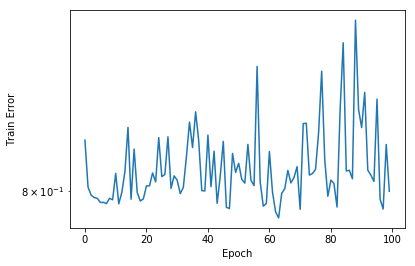

In [30]:
pd.Series(factor.history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

Prediction for the users/movies for the submission

In [27]:
factor.predict(subdf.user_id, subdf.item_id)

predicting...
1176952/1176952 [==============================] - 10s 8us/step
done predicting


Saving the result as a csv file

In [13]:
factor.save(subdf, "../reports/to_submit/neural_fact_5_8_100.csv")

prediction saved at ../reports/to_submit/neural_fact_32_32_100.csv


Export model image

In [12]:
from keras.utils import plot_model
plot_model(factor.model, to_file='../reports/imgs/model_factor.png', show_layer_names=True)

## Collaborative Filtering

Inspiration taken from https://github.com/chen0040/keras-recommender
See `src/models/neural_network/nn.py` for model implementation.

Initialisation and creation of the model

Change this `nonneg` varialble to add a non-negativity constraint on neural networks.

In [13]:
nonneg = True

In [14]:
cf = NeuralCF(nonneg)
cf.create_model(n_users, n_items)
cf.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 100)       1000100     user[0][0]                       
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 100)       100100      item[0][0]                       
__________________________________________________________________________________________________
flatten_1 

Export model image

In [15]:
from keras.utils import plot_model
plot_model(cf.model, to_file='../reports/imgs/model_cf.png', show_layer_names=True)

Training.
Feel free to change the number of `epochs` (default = 10)

In [16]:
cf.train(df, epochs=20)

Train on 1205888 samples, validate on 241178 samples
Epoch 1/20
1205888/1205888 [==============================] - 314s 261us/step - loss: 1.0557 - val_loss: 0.8698
Epoch 2/20
1205888/1205888 [==============================] - 314s 260us/step - loss: 0.9214 - val_loss: 0.8389
Epoch 3/20
1205888/1205888 [==============================] - 308s 256us/step - loss: 0.9065 - val_loss: 0.8190
Epoch 4/20
1205888/1205888 [==============================] - 308s 256us/step - loss: 0.8956 - val_loss: 0.8069
Epoch 5/20
1205888/1205888 [==============================] - 310s 257us/step - loss: 0.8866 - val_loss: 0.8003
Epoch 6/20
1205888/1205888 [==============================] - 313s 260us/step - loss: 0.8797 - val_loss: 0.7922
Epoch 7/20
1205888/1205888 [==============================] - 316s 262us/step - loss: 0.8764 - val_loss: 0.7849
Epoch 8/20
1205888/1205888 [==============================] - 306s 253us/step - loss: 0.8719 - val_loss: 0.7782
Epoch 9/20
1205888/1205888 [=======================

Plot the history

Text(0,0.5,'Train Error')

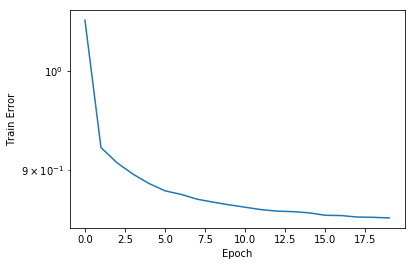

In [20]:
pd.Series(cf.history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

Prediction for the users/movies for the submission

In [21]:
cf.predict(subdf.user_id, subdf.item_id)

predicting...
1176952/1176952 [==============================] - 6s 5us/step
done predicting


Save predictions to a csv file.

In [22]:
cf.save(subdf, "../reports/to_submit/neural_cf_20_nn.csv")

prediction saved at ../reports/to_submit/neural_cf_20_nn.csv
